# Предсказание активности пользователей

<div class='alert-info'>
    Ревьюеру привет). Можешь обращаться ко мне на "Ты".

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.  

Этапы выполнения исследования:
1. Загрузка необходимых бибилиотек и модулей. Чтение датасетов с помощью pandas и получение первой информации о них.
2. Предобработка датасетов.
3. Исследование датасетов и создание новых признаков.
4. Объединение датасетов по уникальным id покупателей.
5. Подготовка данных для обучения моделей и предсказания на обучающей выборке.
6. Проверка лучшей модели на тестовых данных.
7. Анализ важности признаков и окончательный вывод.

## Загрузка и чтение датасетов.

In [ ]:
#импортируем необходимые для работы библиотеки и инструменты из них
import numpy as np
import pandas as pd
import shap
import phik
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
import datetime as dt
import ast
import catboost 

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier

from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler
                                  )
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (roc_auc_score,
                             recall_score,
                             precision_score
                            )
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

RANDOM_STATE = 44
TEST_SIZE = 0.25

In [106]:
pth_1 = 'D:\project\\filtered_data\\apparel-messages.csv'
pth_2 = 'D:\project\\filtered_data\\apparel-purchases.csv'
pth_3 = 'D:\project\\filtered_data\\apparel-target_binary.csv'
#прочитаем таблицы с помощью pandas
messages_data = pd.read_csv(pth_1)
purchases_data = pd.read_csv(pth_2)
target_data = pd.read_csv(pth_3)

In [107]:
print('Таблица с информацией о покупках клиента по дням и по товарам')
display(purchases_data.head())
display(purchases_data.info(show_counts=True))
purchases_data.shape

Таблица с информацией о покупках клиента по дням и по товарам


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

(202208, 6)

In [108]:
print('Таблица с информацией о рассылках, отправленных клиентам')
display(messages_data.head())
display(messages_data.info(show_counts=True))
messages_data.shape

Таблица с информацией о рассылках, отправленных клиентам


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Non-Null Count     Dtype 
---  ------            --------------     ----- 
 0   bulk_campaign_id  12739798 non-null  int64 
 1   client_id         12739798 non-null  int64 
 2   message_id        12739798 non-null  object
 3   event             12739798 non-null  object
 4   channel           12739798 non-null  object
 5   date              12739798 non-null  object
 6   created_at        12739798 non-null  object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

(12739798, 7)

In [109]:
print('Таблица с целевым признаком')
display(target_data.head())
display(target_data.info(show_counts=True))
target_data.shape

Таблица с целевым признаком


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

(49849, 2)

Данные были успешно загружены и прочитаны. Во всех колонках таблиц соблюдаеться единый стиль названий колонок. Пропусков в данных нет. От дубликатов избавимся при присоединении уже агрегированных таблиц оставив id только только тех, что есть в таблице "target_".  

Колонки с датами переведем к соответствующему типу.

## Предобработка данных.

In [110]:
#изменим типы данных
purchases_data['date'] = pd.to_datetime(
        purchases_data['date'], format='%Y-%m-%d'
    )
messages_data['date'] = pd.to_datetime(
        messages_data['date'], format='%Y-%m-%d'
    )
messages_data['created_at'] = pd.to_datetime(
    messages_data['created_at'], format='%Y-%m-%d %H:%M:%S'
)

Проверим таблицы на полные и неполные дубликаты

In [111]:
print(f'Полных дубликатов в таблице с покупками - {purchases_data.duplicated().sum()}')
print(f'Полных дубликатов в таблице с оповещениями - {messages_data.duplicated().sum()}')
print(f'Полных дубликатов в таблице с таргетом - {target_data.duplicated().sum()}')

Полных дубликатов в таблице с покупками - 73020
Полных дубликатов в таблице с оповещениями - 48610
Полных дубликатов в таблице с таргетом - 0


Так как в таблице с оповещениями есть метка времени создания рассылки, полные дубликаты можно удалить без последствий.  
Чего нельзя сказать про таблицу с покупками, потому что допускается, когда один и тот же человек, мог купить одинаковый товар несколько раз в день.

In [112]:
messages_data = messages_data.drop_duplicates()

In [113]:
#функция для проверки неполных дублей
def unique_check(data, columns):
    for i in columns:
        print(f'Cтолбец: - {i}')
        print(data[i].sort_values().unique())

In [114]:
unique_check(messages_data, ['event', 'channel'])

Cтолбец: - event
['click' 'close' 'complain' 'hard_bounce' 'hbq_spam' 'open' 'purchase'
 'send' 'soft_bounce' 'subscribe' 'unsubscribe']
Cтолбец: - channel
['email' 'mobile_push']


В таблице с оповещениями проблем с категориями нет, неполных дублей тоже нет.
Обратим внимание на такие категории как: "close", "hard_bounce", "hbq_spam", "unsubscribe", "complain" все они представляют из себя негативный отклик на оповещение со стороны клиента, а значит могут повлиятть на его желание купить товар в магазине. Разделим такие категории создав новую колонку и присвоив им соответствующие пометки.

In [115]:
bad_event = ['close', 'complain', 'hard_bounce', 'hbq_spam', 'unsubscribe']

messages_data['event_type'] = messages_data['event'].apply(lambda x: 'bad_event'
                                                                      if x in bad_event
                                                                      else 'good_event'
                                                                            if x != 'send'
                                                                            else 'neutral_event')
messages_data.sample(5)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,event_type
11477061,14456,1515915625488377909,1515915625488377909-14456-659fb052a7f73,send,mobile_push,2024-01-11,2024-01-11 11:13:55,neutral_event
10979209,14410,1515915625477689016,1515915625477689016-14410-658e6f2b6864e,open,mobile_push,2023-12-29,2023-12-29 07:13:53,good_event
6884236,13626,1515915625500893422,1515915625500893422-13626-64d497ad4dc67,send,email,2023-08-11,2023-08-11 06:05:54,neutral_event
1677561,6783,1515915625487678809,1515915625487678809-6783-6334027c841e7,send,email,2022-09-28,2022-09-28 08:16:34,neutral_event
2669982,8033,1515915625736734503,1515915625736734503-8033-637dbe3f29a35,open,email,2022-11-23,2022-11-23 13:21:43,good_event


In [116]:
unique_check(purchases_data, ['category_ids'])

Cтолбец: - category_ids
["['1', '22', '50', '685']" "['1', '8', '280', '710']"
 "['2', '17', '107', '453']" "['2', '17', '137', '469']"
 "['2', '17', '171', '475']" "['2', '17', '173', '1598']"
 "['2', '17', '173', '1845']" "['2', '17', '173', '459']"
 "['2', '17', '180', '465']" "['2', '17', '1826', '1818']"
 "['2', '17', '188', '525']" "['2', '17', '198', '497']"
 "['2', '17', '232', '463']" "['2', '17', '279', '5807']"
 "['2', '17', '286', '455']" "['2', '17', '293', '5819']"
 "['2', '17', '330', '387', '467']" "['2', '17', '83', '519']"
 "['2', '17', '83', '5810']" "['2', '18', '123', '451']"
 "['2', '18', '155', '1325']" "['2', '18', '155', '439']"
 "['2', '18', '212', '658']" "['2', '18', '212', '659']"
 "['2', '18', '212', '726']" "['2', '18', '217', '662']"
 "['2', '18', '217', '663']" "['2', '18', '243', '440']"
 "['2', '18', '248', '449']" "['2', '18', '248', '677']"
 "['2', '18', '258', '1195']" "['2', '18', '258', '1561']"
 "['2', '18', '258', '1562']" "['2', '18', '258', '

В колонке с категориями товаром есть категории с пустыми или пропущенными значениями их можно убрать.  
Из этой же колонки выведем первую как основную, чтобы уменьшить число уникальных значений.

In [117]:
print(purchases_data.shape)
purchases_data = purchases_data.loc[(purchases_data['category_ids'] != '[None]') & (purchases_data['category_ids'] != '[]')]
purchases_data.shape

(202208, 6)


(195365, 6)

In [118]:
'''
учитывая особенности записи категорий предположим, что еденичные категории представляют собой разделение на мужское\женское или распродажные вкладки
исключением будут если еденичная категория стоит на втором месте списка, потому что тогда уже можно сказать, что это конкретная основная категория магазина
'''
purchases_data['main_category_ids'] = purchases_data.category_ids.apply(lambda x: ast.literal_eval(x))
purchases_data['main_category_ids'] = purchases_data['main_category_ids'].apply(lambda x: x[0]
                                                                                          if len(str(x[0])) > 1
                                                                                          else x[1]
                                                                                )
unique_check(purchases_data, ['main_category_ids'])
purchases_data.sample(5)

Cтолбец: - main_category_ids
['10' '12' '14' '17' '18' '1822' '22' '27' '28' '29' '30' '31' '44' '5562'
 '5837' '5963' '6060' '8']


,client_id,quantity,price,category_ids,date,message_id,main_category_ids
22803,1515915625553960655,1,2999.0,"['2', '18', '212', '726']",2022-07-11,1515915625491505866-5335-62c7d2d6ba521,18
33325,1515915625487431657,1,2299.0,"['5562', '5631', '5700', '448']",2022-08-24,1515915625487431657-5922-62ff3561ba05c,5562
185458,1515915625476712654,1,1049.0,"['4', '28', '275', '421']",2023-12-23,1515915625476712654-14352-65855843ddfb2,28
64161,1515915625602435611,1,1749.0,"['6060', '6058', '6067', '5498']",2022-12-14,1515915625602435611-8663-6399c91c4d751,6060
152175,1515915625501343073,1,1246.0,"['4', '28', '244', '432']",2023-07-04,1515915625501343073-13436-64a2c7d87928d,28


In [119]:
#добавим так же колонку с выручкой для таблицы с покупками
purchases_data['revenue'] = purchases_data['price'] * purchases_data['quantity']
purchases_data.sample(5)

,client_id,quantity,price,category_ids,date,message_id,main_category_ids,revenue
172996,1515915625468144578,1,2062.0,"['2', '18', '61', '660']",2023-10-09,1515915625468144578-13898-651c021352f3b,18,2062.0
188026,1515915625489610619,1,1050.0,"['4', '31', '324', '466']",2023-12-26,1515915625489610619-14387-6589a72eb834b,31,1050.0
144518,1515915625491589610,1,205.0,"['5562', '5633', '5611', '713']",2023-06-23,1515915625491589610-13392-64955528579b0,5562,205.0
16186,1515915625669751480,1,599.0,"['2', '18', '212', '726']",2022-06-22,1515915625669751480-5052-62b2c1b19c834,18,599.0
39260,1515915625798108924,1,1999.0,"['4', '28', '213', '436']",2022-09-11,1515915625798108924-6289-631ada4004e82,28,1999.0


Создадим колонки с месяцами и годами для датасетов, чтобы увидеть в исследовании максимальные и минимальные.

In [120]:
#таблица с оповещениями
messages_data['year'] = messages_data['date'].dt.year
messages_data['month'] = messages_data['date'].dt.month

#таблица с покупками
purchases_data['year'] = purchases_data['date'].dt.year
purchases_data['month'] = purchases_data['date'].dt.month

Данные проверены и очищены, перейдем к исследованию.

## Исследовательский аналих данных.

Исследуем сначала категориальные признаки.

In [121]:
#построим графики распределения категорий в таблицах
cat_list_mes_s = ['event', 'channel', 'event_type']
#используем функцию
def bar_build(data, ittor):
    for i in ittor:
        print(f'Распределение в колонке - {i}')
        value_counts = data[i].value_counts()
        plt.figure(figsize=(10, 6))
        plt.bar(value_counts.index, value_counts.values)
        plt.title('Гистограмма распределения')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('Категория')
        plt.ylabel('Сумма значений каждой категории')
        plt.grid(True)
        plt.show()

Распределение в колонке - event


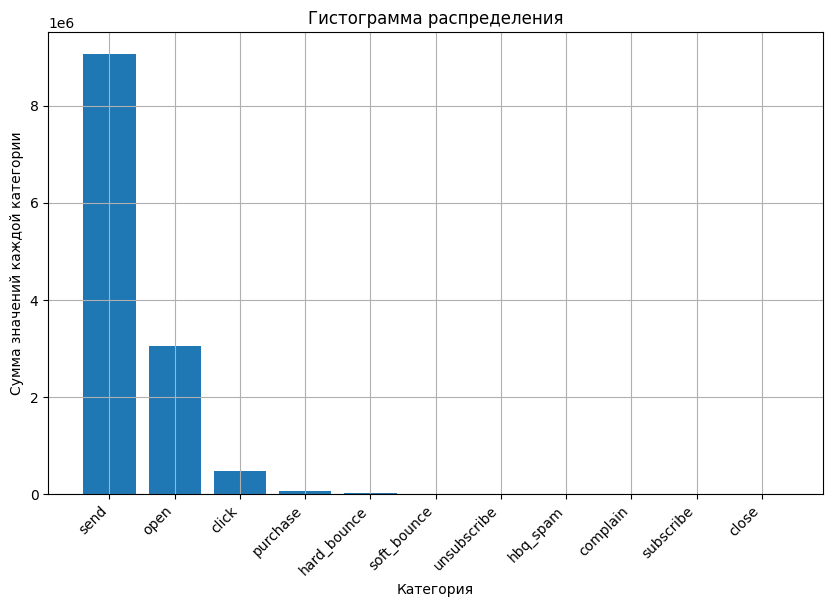

Распределение в колонке - channel


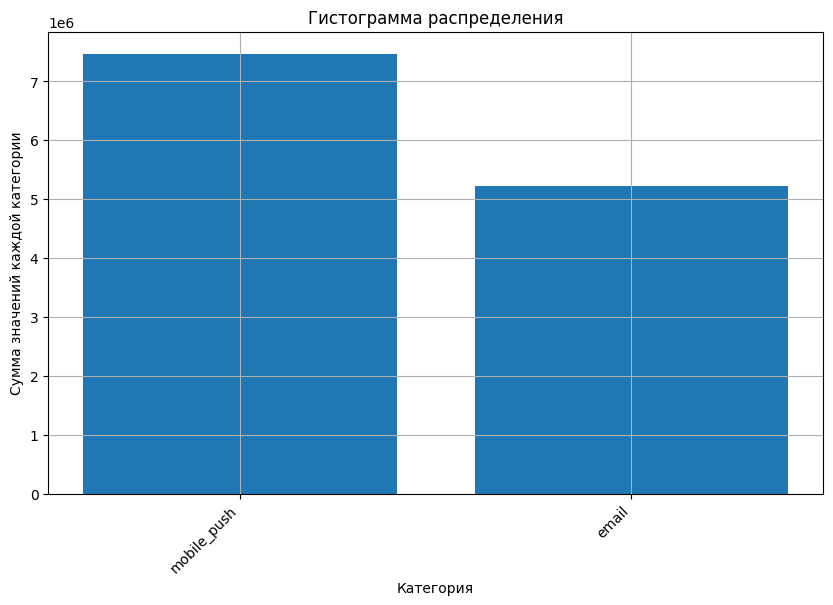

Распределение в колонке - event_type


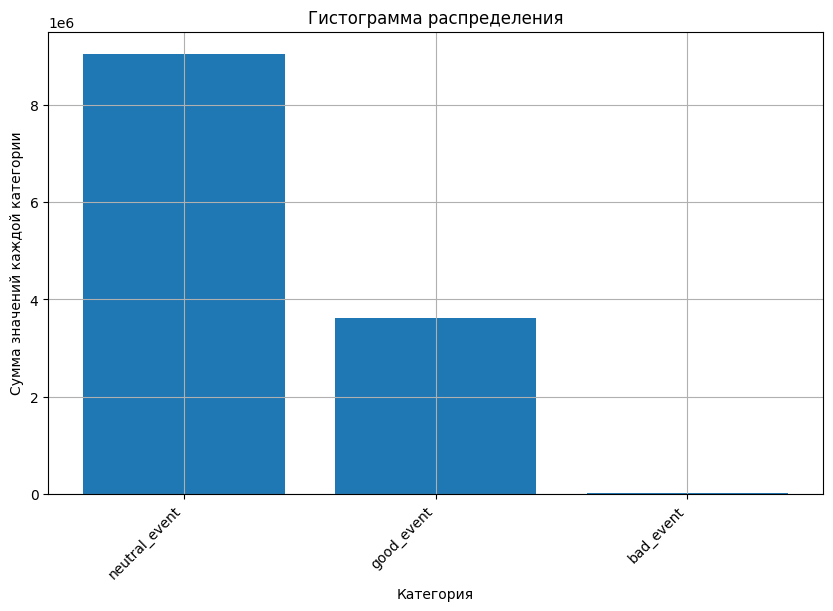

In [122]:
bar_build(messages_data, cat_list_mes_s)

Рассмотрев значения в колонках можно выделить несколько моментов:
1. В колонке с типом ивента
* большинство сообщений помечены просто как "отправленные", а значит с ними еще не произвели никаких действий, чтобы их различить;
* много сообдений были открыты, относительно других категорий, а значит и прочитаны;
* еще меньше сообщений привели к переходу на сайт;
* всех остальных событий слишком мало, чтобы их оценить.
2. В колонке с каналом получения сообщения:
* большая часть была отправлены в виде пуш-уведомления;
* рассылка на почту меньше примерно на 1/6 от пуш-уведомлений.
3. В колонке с типом ивента
* большая часть сообщений пока в нейтральном положении и никак не повлияли на получателя;
* благоприятных событий значительно больше, неблагоприятных, это хороший показатель.

Таблица с покупками почти все колонки числовые, поэтому исследуем только новую колонку с категориями.

Распределение в колонке - main_category_ids


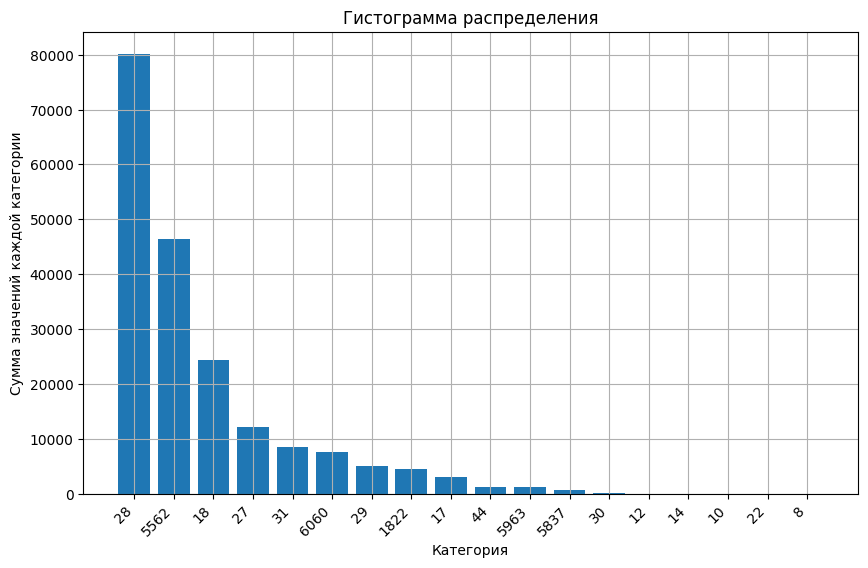

In [123]:
bar_build(purchases_data, ['main_category_ids'])

Категория под кодом "28" самая популярная, следом идет "5562" и "18", для уточнения можно было бы запросить расшифровку этих категорий, но модели это не требуется.

Выведем общую информацию по числовым значениям.

In [124]:
purchases_data.describe()

,client_id,quantity,price,revenue,year,month
count,1.953650e+05,195365.000000,195365.000000,195365.000000,195365.000000,195365.000000
mean,1.515916e+18,1.006711,1233.400768,1239.795961,2022.646549,7.215663
std,1.457083e+08,0.187581,1341.477942,1354.512783,0.578838,3.279036
min,1.515916e+18,1.000000,1.000000,1.000000,2022.000000,1.000000
25%,1.515916e+18,1.000000,399.000000,399.000000,2022.000000,5.000000
50%,1.515916e+18,1.000000,999.000000,999.000000,2023.000000,7.000000
75%,1.515916e+18,1.000000,1728.000000,1745.000000,2023.000000,11.000000
max,1.515916e+18,30.000000,85499.000000,85499.000000,2024.000000,12.000000


Из самого очевидного можно выделить:
* максимальное число покупок - 30;
* максимальная цена товара 85499 - минимальная 1;
* год начала сбора данных 2022, а окончания 2024;

Рассмотрим таблицу с покупками подробнее, выведем распределние цен, и кол-ва покупок в них.

Колонка - "price"


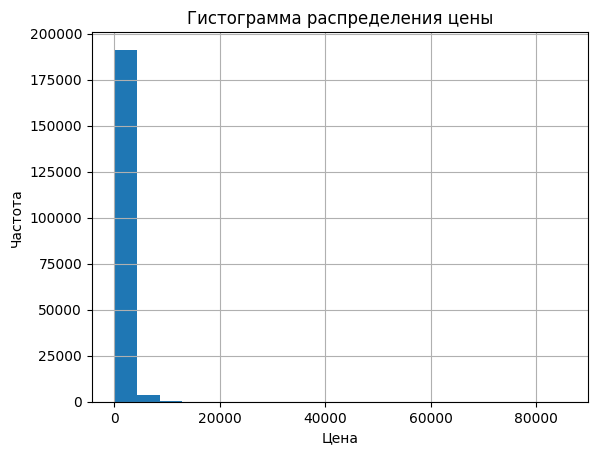

In [125]:
print(f'Колонка - "price"')
purchases_data['price'].plot(kind='hist', bins=20)
plt.title('Гистограмма распределения цены')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Колонка - "quantity"


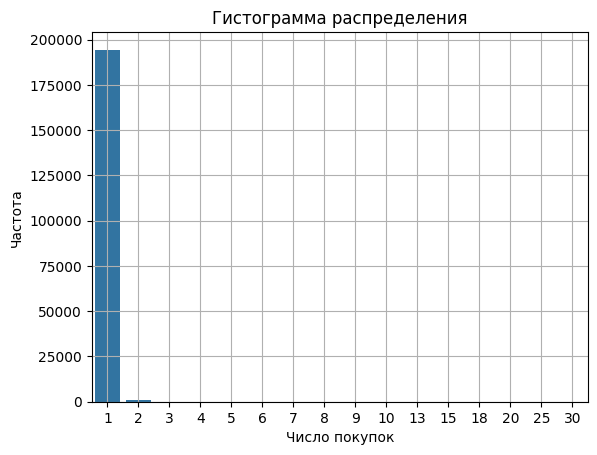

In [126]:
print(f'Колонка - "quantity"')
sns.countplot(purchases_data, x='quantity')
plt.title('Гистограмма распределения')
plt.grid(True)
plt.xlabel('Число покупок')
plt.ylabel('Частота')
plt.show()

В глобальном плане слишком большая разница между значениями, рассмотрим их относительно годов и месяцев

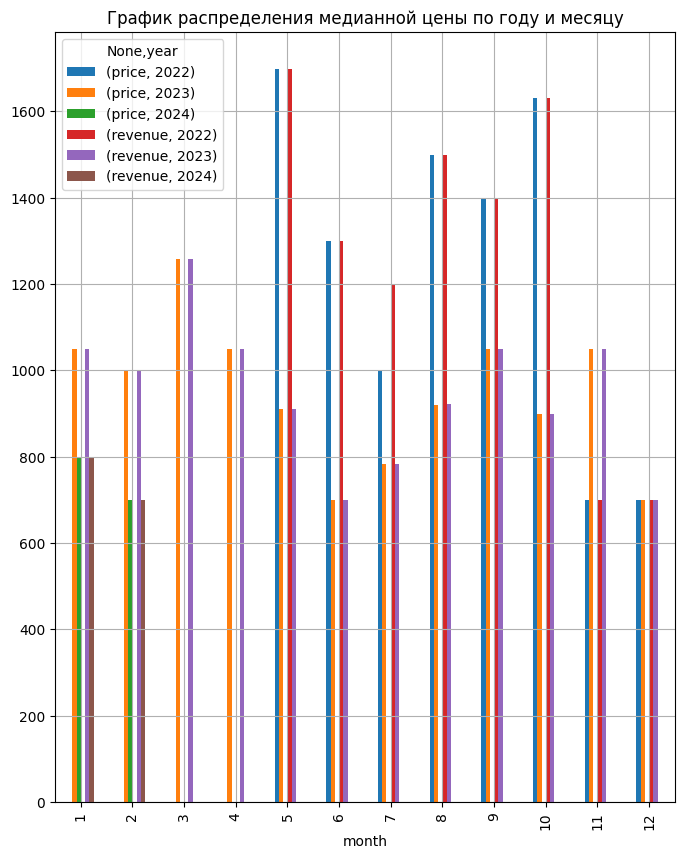

In [127]:
purchases_data.pivot_table(index='month', columns='year', values=['price', 'revenue'], aggfunc='median').plot(kind='bar', figsize=(8, 10), grid=True, legend=True)
plt.title('График распределения медианной цены по году и месяцу')
plt.show()

Построим такой же график и для числа покупок

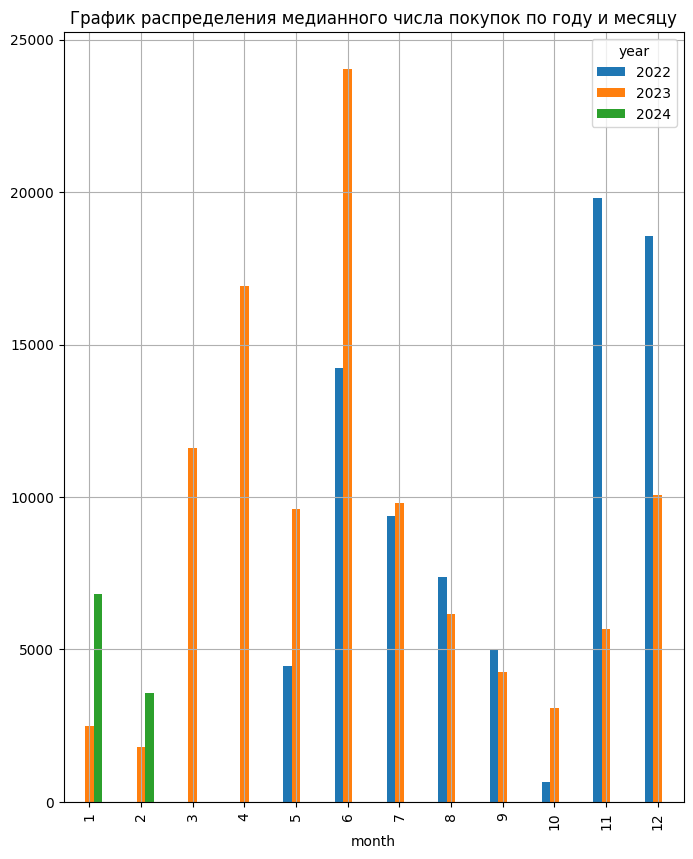

In [128]:
purchases_data.pivot_table(index='month', columns='year', values='quantity', aggfunc='count').plot(kind='bar', figsize=(8, 10), grid=True, legend=True)
plt.title('График распределения медианного числа покупок по году и месяцу')
plt.show()

Первое что стоит выделить, это месяцы в которые начинается и заканчивается сбор данных о действиях клиентов, а именно май 2022 и февраль 2024, значит в распоряжении имеется информация о 21 месяце.  
Цена с каждым годом меняется в меньшую сторону.  
В 2022 году самый большой скачок покупок был на два последних месяца года, как раз в предверии праздников, но в 2023 скачки приходятся на апрель и июнь, а в конце года не так сильно, как в прошлом.  

## Агрегирование и объединение таблиц

In [129]:
#посчитаем для таблицы с сообщениями общее число ивентов для уникального клиента
a_1 = messages_data.pivot_table(index='client_id', values='event', aggfunc='count')
a_1.columns = ['event_count']
a_2 = messages_data.groupby('client_id').agg(event_mode=('event_type', lambda x: x.mode().iat[0]))
a_2.reset_index()

,client_id,event_mode
0,1515915625468060902,neutral_event
1,1515915625468061003,neutral_event
2,1515915625468061099,neutral_event
3,1515915625468061100,neutral_event
4,1515915625468061170,neutral_event
...,...,...
53324,1515915626010183608,good_event
53325,1515915626010221592,good_event
53326,1515915626010234726,neutral_event
53327,1515915626010261344,good_event


In [ ]:
#посчитаем число событий по каждому типу
a = messages_data.groupby(by='client_id')['event_type'].value_counts().to_frame()
a = a.unstack('event_type').fillna(0)
a.columns = [tup[1] if tup[1] else tup[0] for tup in a.columns]
#объединим таблицу с общим числом и событий по типам чтобы посчитать конверсии между ними
a = pd.merge(a, a_1, on='client_id', how='left')
a = pd.merge(a, a_2, on='client_id', how='left')
a.reset_index()

,client_id,bad_event,good_event,neutral_event,event_count,event_mode
0,1515915625468060902,1.0,50.0,126.0,177,neutral_event
1,1515915625468061003,0.0,11.0,154.0,165,neutral_event
2,1515915625468061099,2.0,59.0,215.0,276,neutral_event
3,1515915625468061100,1.0,160.0,267.0,428,neutral_event
4,1515915625468061170,0.0,50.0,243.0,293,neutral_event
...,...,...,...,...,...,...
53324,1515915626010183608,0.0,2.0,2.0,4,good_event
53325,1515915626010221592,0.0,4.0,2.0,6,good_event
53326,1515915626010234726,0.0,0.0,1.0,1,neutral_event
53327,1515915626010261344,0.0,2.0,1.0,3,good_event


In [ ]:
#выделим моду для канала рассылки на клиента
b_1 = messages_data.groupby('client_id').agg(channel_mode=('channel', lambda x: x.mode().iat[0]))
b_1.reset_index()

,client_id,channel_mode
0,1515915625468060902,email
1,1515915625468061003,email
2,1515915625468061099,email
3,1515915625468061100,mobile_push
4,1515915625468061170,email
...,...,...
53324,1515915626010183608,mobile_push
53325,1515915626010221592,mobile_push
53326,1515915626010234726,mobile_push
53327,1515915626010261344,mobile_push


In [ ]:
#посчитаем число категорий передачи сообщения для каждого уникального клиента 
b = messages_data.groupby('client_id')['channel'].value_counts().to_frame().unstack('channel').fillna(0)
b.columns = [tup[1] if tup[1] else tup[0] for tup in b.columns]
#объединим число категорий и моду по ним же
b = pd.merge(b, b_1, on='client_id', how='left')
b.reset_index()

,client_id,email,mobile_push,channel_mode
0,1515915625468060902,177.0,0.0,email
1,1515915625468061003,165.0,0.0,email
2,1515915625468061099,182.0,94.0,email
3,1515915625468061100,0.0,428.0,mobile_push
4,1515915625468061170,202.0,91.0,email
...,...,...,...,...
53324,1515915626010183608,0.0,4.0,mobile_push
53325,1515915626010221592,0.0,6.0,mobile_push
53326,1515915626010234726,0.0,1.0,mobile_push
53327,1515915626010261344,0.0,3.0,mobile_push


In [133]:
#посчитаем выручку на клиента, число покупок и самую частую категорию в магазине
c = purchases_data.groupby('client_id').agg(revenue_sum=('revenue', 'sum'), quantity_total=('quantity', 'count'), cat=('main_category_ids', lambda x: x.mode().iat[0]))
c.reset_index()

,client_id,revenue_sum,quantity_total,cat
0,1515915625468060902,6993.0,7,28
1,1515915625468061003,16235.0,7,28
2,1515915625468061099,299.0,1,28
3,1515915625468061100,2098.0,2,27
4,1515915625468061170,33587.0,17,28
...,...,...,...,...
49843,1515915626010261344,8994.0,6,18
49844,1515915626010266132,1818.0,2,27
49845,1515915626010439406,198.0,2,27
49846,1515915626010443527,1999.0,1,18


In [ ]:
#найдем число дней с момента последней покупки
c_1 = purchases_data.groupby('client_id').agg(date_max=('date', lambda x: x.max()), date_min=('date', lambda x: x.min()))
c_1['last_purchases_days'] = (c_1['date_max']-c_1['date_min']).dt.days
c_1.reset_index()
#добавим новый столбце к основной таблице
c = pd.merge(c, c_1, on='client_id', how='left')

In [135]:
#объединим таблицы
data_first = pd.merge(target_data, a, on='client_id', how='left')
data_second = pd.merge(data_first, b, on='client_id', how='left')
data = pd.merge(data_second, c, on='client_id', how='left')
data = data.dropna().reset_index(drop=True)
print(f'Таблица с объединенными данными')
display(data)
data.info()

Таблица с объединенными данными


,client_id,target,bad_event,good_event,neutral_event,event_count,event_mode,email,mobile_push,channel_mode,revenue_sum,quantity_total,cat,date_max,date_min,last_purchases_days
0,1515915625468060902,0,1.0,50.0,126.0,177.0,neutral_event,177.0,0.0,email,6993.0,7.0,28,2022-05-27,2022-05-27,0.0
1,1515915625468061003,1,0.0,11.0,154.0,165.0,neutral_event,165.0,0.0,email,16235.0,7.0,28,2023-01-04,2023-01-04,0.0
2,1515915625468061099,0,2.0,59.0,215.0,276.0,neutral_event,182.0,94.0,email,299.0,1.0,28,2022-05-17,2022-05-17,0.0
3,1515915625468061100,0,1.0,160.0,267.0,428.0,neutral_event,0.0,428.0,mobile_push,2098.0,2.0,27,2024-02-10,2024-02-10,0.0
4,1515915625468061170,0,0.0,50.0,243.0,293.0,neutral_event,202.0,91.0,email,33587.0,17.0,28,2023-06-17,2023-03-26,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41976,1515915626010079153,0,0.0,2.0,1.0,3.0,good_event,0.0,3.0,mobile_push,15929.0,8.0,18,2024-02-13,2024-02-13,0.0
41977,1515915626010152263,0,0.0,4.0,1.0,5.0,good_event,0.0,5.0,mobile_push,1676.0,4.0,18,2024-02-14,2024-02-14,0.0
41978,1515915626010183608,0,0.0,2.0,2.0,4.0,good_event,0.0,4.0,mobile_push,558.0,2.0,5562,2024-02-13,2024-02-13,0.0
41979,1515915626010221592,0,0.0,4.0,2.0,6.0,good_event,0.0,6.0,mobile_push,2998.0,2.0,28,2024-02-16,2024-02-16,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41981 entries, 0 to 41980
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   client_id            41981 non-null  int64         
 1   target               41981 non-null  int64         
 2   bad_event            41981 non-null  float64       
 3   good_event           41981 non-null  float64       
 4   neutral_event        41981 non-null  float64       
 5   event_count          41981 non-null  float64       
 6   event_mode           41981 non-null  object        
 7   email                41981 non-null  float64       
 8   mobile_push          41981 non-null  float64       
 9   channel_mode         41981 non-null  object        
 10  revenue_sum          41981 non-null  float64       
 11  quantity_total       41981 non-null  float64       
 12  cat                  41981 non-null  object        
 13  date_max             41981 non-

In [136]:
#добавим конверсии для событий
data['bad_event_convrsn'] = data['bad_event'] / data['event_count']
data['good_event_convrsn'] = data['good_event'] / data['event_count']
data['neutral_event_convrsn'] = data['neutral_event'] / data['event_count']
data['email_convrsn'] = data['email'] / data['event_count']
data['mobile_push'] = data['mobile_push'] / data['event_count']
display(data.sample(5))
data.info()

,client_id,target,bad_event,good_event,neutral_event,event_count,event_mode,email,mobile_push,channel_mode,revenue_sum,quantity_total,cat,date_max,date_min,last_purchases_days,bad_event_convrsn,good_event_convrsn,neutral_event_convrsn,email_convrsn
15577,1515915625491119871,0,0.0,209.0,314.0,523.0,neutral_event,277.0,0.470363,email,10492.0,8.0,18,2023-05-26,2022-05-20,371.0,0.0,0.399618,0.600382,0.529637
7427,1515915625488177093,0,0.0,13.0,293.0,306.0,neutral_event,99.0,0.676471,mobile_push,1299.0,1.0,28,2022-07-10,2022-07-10,0.0,0.0,0.042484,0.957516,0.323529
3174,1515915625471286286,0,0.0,52.0,251.0,303.0,neutral_event,98.0,0.676568,mobile_push,5996.0,4.0,28,2022-06-18,2022-06-18,0.0,0.0,0.171617,0.828383,0.323432
31852,1515915625634123749,0,0.0,29.0,22.0,51.0,good_event,51.0,0.000000,email,1998.0,2.0,28,2022-09-06,2022-07-14,54.0,0.0,0.568627,0.431373,1.000000
27496,1515915625569791248,0,0.0,60.0,349.0,409.0,neutral_event,155.0,0.621027,mobile_push,17681.0,21.0,31,2023-06-16,2022-06-01,380.0,0.0,0.146699,0.853301,0.378973


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41981 entries, 0 to 41980
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   client_id              41981 non-null  int64         
 1   target                 41981 non-null  int64         
 2   bad_event              41981 non-null  float64       
 3   good_event             41981 non-null  float64       
 4   neutral_event          41981 non-null  float64       
 5   event_count            41981 non-null  float64       
 6   event_mode             41981 non-null  object        
 7   email                  41981 non-null  float64       
 8   mobile_push            41981 non-null  float64       
 9   channel_mode           41981 non-null  object        
 10  revenue_sum            41981 non-null  float64       
 11  quantity_total         41981 non-null  float64       
 12  cat                    41981 non-null  object        
 13  d

Пропущенных значений нет, объединение и добавление новых признаков прошло без проблем.

<div class='alert-info'>
    имена для таблиц изменю позже, пока для собственного удобства сделаю так, слишком много раз я менял их содержание)

## Корреляционный анализ признаков

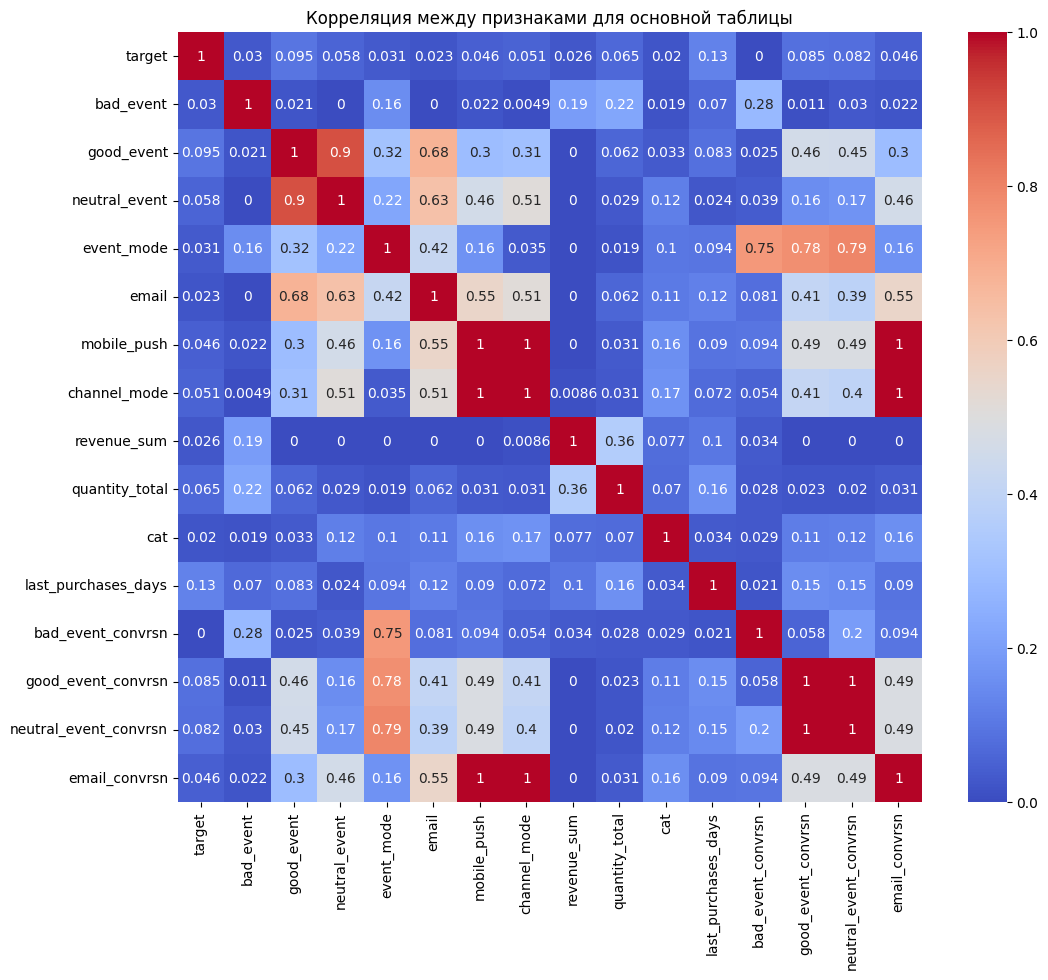

In [137]:
#используем для этого более подходящую библитеку phik,
#которая может найти коэффициент корреляции между числовыми и категориальными признаками
data_corr = data.drop(['event_count',
                        'client_id',
                        'date_max',
                        'date_min'], axis=1)
data_corr = data_corr.phik_matrix(
    interval_cols=['bad_event',
                   'good_event',
                   'neutral_event',
                   'email', 
                   'mobile_push',
                   'revenue_sum',
                   'quantity_total',
                   'bad_event_convrsn',
                   'good_event_convrsn',
                   'neutral_event_convrsn',
                   'email_convrsn',
                   'last_purchases_days'
                  ]
)
plt.figure(figsize=(12, 10))
sns.heatmap(data_corr, annot=True, cmap='coolwarm')
plt.title('Корреляция между признаками для основной таблицы')
plt.show()

Судя по матрице корреляции число нейтральных событий сильно коррелирует с числом хороших событий, то же относиться и к конверсиям этих двух столбцов, поэтому для модели оставим только число хороших событий и их отношение к общему числу.

## Обучение моделей

In [138]:
#оставим только нужные признаки для обучения модели
data_train = data.drop(['client_id',
                        'neutral_event_convrsn',
                        'event_count',
                        'date_max',
                        'neutral_event',
                        'date_min'], axis=1)

#разделим данные на две выборки
X_train, X_test, y_train, y_test = train_test_split(
    data_train.drop(['target'], axis=1),
    data_train['target'],
    stratify=data_train['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

In [139]:
#разделим колонки по категориальным и числовым
ohe_column = ['cat', 'channel_mode']
num_columns = ['revenue_sum',
               'quantity_total',
               'last_purchases_days',
               'email_convrsn',
               'bad_event',
               'good_event',
               'email', 
               'mobile_push',
               'bad_event_convrsn',
               'good_event_convrsn']
ord_column = ['event_mode']

In [140]:
#используем пайплайн для подготовки данных
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
ord = OrdinalEncoder(
                categories=[['bad_event', 'neutral_event', 'good_event']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe, ohe_column),
        ('ord', ord, ord_column),
        ('num', RobustScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [141]:
pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression())
    ]
)

In [142]:
#саздадим гиперпараметры для моделей и для перебора методов масштабирования для числовых признаков
param_grid = [
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },
    {
        'models':[KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [143]:
#через автоматический перебор моделей найдем лучшую
randomized_search = RandomizedSearchCV(
    pipe, 
    param_grid, 
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [144]:
randomized_search.fit(X_train, y_train)
#выведем лучшую модель и её параметры
print('Метрика roc_auc для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

One or more of the test scores are non-finite: [0.69227231        nan 0.69229228 0.69205311 0.69231387 0.59531749
 0.62345681 0.59739644 0.69228513 0.69227987]


Метрика roc_auc для лучшей модели:
 0.6923138690479559

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['cat', 'channel_mode']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['bad_event',
                                                                              'neutral_event',
                                                                              'good_event']],
                                                                 handle_unknown='use_encoded_val

Инициализируем CatBoostRegressor

In [145]:
cat = CatBoostClassifier(grow_policy='Depthwise',
                        learning_rate=0.05,
                        random_state=RANDOM_STATE,
                        cat_features=(ohe_column+ord_column),
                        verbose=15,
                        class_weights=[1, 60])

param = {
    'depth': range(10, 15),
    'iterations': range(15, 18)
}

random_cat = RandomizedSearchCV(cat, param, n_iter=15, scoring='roc_auc', random_state=RANDOM_STATE, )
random_cat.fit(X_train, y_train)

0:	learn: 0.6859127	total: 127ms	remaining: 1.77s
14:	learn: 0.5997032	total: 2.63s	remaining: 0us
0:	learn: 0.6844757	total: 147ms	remaining: 2.06s
14:	learn: 0.5982437	total: 2.23s	remaining: 0us
0:	learn: 0.6844375	total: 154ms	remaining: 2.16s
14:	learn: 0.5980696	total: 2.42s	remaining: 0us
0:	learn: 0.6825840	total: 163ms	remaining: 2.28s
14:	learn: 0.5951107	total: 3.68s	remaining: 0us
0:	learn: 0.6849110	total: 189ms	remaining: 2.65s
14:	learn: 0.5981148	total: 2.72s	remaining: 0us
0:	learn: 0.6859127	total: 153ms	remaining: 2.29s
15:	learn: 0.5958729	total: 2.56s	remaining: 0us
0:	learn: 0.6844757	total: 136ms	remaining: 2.04s
15:	learn: 0.5929683	total: 2.51s	remaining: 0us
0:	learn: 0.6844375	total: 137ms	remaining: 2.05s
15:	learn: 0.5935494	total: 2.39s	remaining: 0us
0:	learn: 0.6825840	total: 149ms	remaining: 2.24s
15:	learn: 0.5909073	total: 2.42s	remaining: 0us
0:	learn: 0.6849110	total: 148ms	remaining: 2.23s
15:	learn: 0.5943134	total: 2.47s	remaining: 0us
0:	learn: 

RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x0000022000C7F880>,
                   n_iter=15,
                   param_distributions={'depth': range(10, 15),
                                        'iterations': range(15, 18)},
                   random_state=44, scoring='roc_auc')

In [146]:
print(f'Лучшее значение метрики roc_auc на тренировочной выборке - {round(random_cat.best_score_, 2)}')
print(f'Параметры лучшей модели - {random_cat.cv_results_["params"][random_cat.best_index_]}')

Лучшее значение метрики roc_auc на тренировочной выборке - 0.71
Параметры лучшей модели - {'iterations': 15, 'depth': 10}


Добавим проверку через dummy_classifier

In [150]:
#определим базовую модель
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке для базового классификатора модели: {roc_auc_score(y_test, dummy_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке для базового классификатора модели: 0.5


## Проверка модели на тестовых данных

Теперь проверим предсказание нашей лучшей модели на тестовых данных

In [ ]:
y_pred = random_cat.predict(X_test)
y_test_pred = random_cat.predict_proba(X_test)[:, 1]
print(f'ROC-AUC для тестовой выборки равен - {round(roc_auc_score(y_test, y_test_pred), 2)}')
print(f'Recall для модели равен - {round(recall_score(y_test, y_pred), 2)}')
print(f'Precision для модели равен - {round(precision_score(y_test, y_pred), 2)}')

ROC-AUC для тестовой выборки равен - 0.7143474384095462
Recall для модели равен - 0.7028301886792453
Precision для модели равен - 0.034213547646383465


Проверим распределение правильных ответов модели к неправильным через confusion_matrix

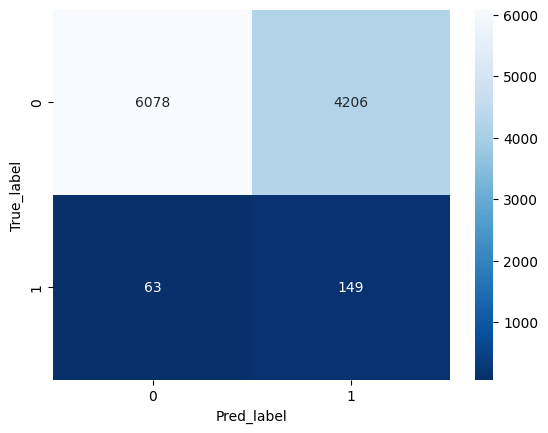

In [149]:
#настроим вывод матрицы
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.xlabel('Pred_label')
plt.ylabel('True_label')
plt.show()

Модель сделала 149 правильных предсказаний нужного класса, но так же присвоила ноль еще 63 потенциальным клиентам. Еще 4206 человек неправильно попали в класс 1, но это не такая большая проблема, вряд-ли человек ошибочно получивший предложение от магазина будет сильно недоволен этим, если ему не будут спамить этими предложениями.

<div class='alert-info'>
    Я банально не успеваю сделать график важности признаков через shap, уже нужно читать теорию следующего спринта. Не успел прошлый проект вовремя сдать, сделал много ошибок и задержался на неделю и поэтому на эту работу потратил всего неделю, надеюсь смог добиться подобающего результата.

## Общий вывод

В ходе работы были использованы данные о сообщениях, покупках и клиентах, которые совершили покупку в целевой период. Данные были просмотренны и предобработанны, пропуски и дубликаты были устранены, аномалии не замечены, были добавлены дополнительные столбцы с полезной для исследования информацией.  
На основании данных были созданы признаки для обучения модели в них вошли: подсчеты числа категорий типа ивента и канала рассылки; мода по категории ивента и канала рассылки для клиента; общее число ивентов на клиента; выручка клиента; число покупок клиента; количество дней с момента последней покупки и отношение числа категорий из таблицы с рассылками к общему числу событий на клиента.  

По информации из матрицы корреляции несколько признаков необходимо было убрать, чтобы не усложнять обучение модели.

Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время. Для этого были обучены четыре вида моделей с разными параметрами, дабы выявить лучшее сочетание. По итогу обучения лучше показала себя модель **CatBoostClassification** cо следующими основными параметрами: **grow_policy='Depthwise', learning_rate=0.05, class_weights=[1, 60]**. Метрика ROC AUC данной модели на тестовой выборке - 0.71. Результат приемлемый и если добавить больше признаков, можно улучшить модель и её предсказания.  

Уже даже с такой моделью, можно привлечь к новым покупкам 70% пользователей дополнительными предложениями и скидками, конечно это не гарантия самой покупки, но без таких уведомлений они бы могли пропустить "тот самый" товар.